<a href="https://colab.research.google.com/github/e-chong/Singapore-Ship-Detection/blob/master/Download_Sentinel_2_Imagery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Sentinel-2 Imagery

This notebook downloads sentinel-2 imagery

# 1. Setup Environment

In [2]:
# install libraries
!pip install rasterio
!pip install geopandas
!pip install sentinelsat
!pip install satpy
!pip install glymur
!pip install python-geotiepoints
!pip install pyspectral

     |████████████████████████████████| 18.1MB 231kB/s 
     |████████████████████████████████| 931kB 2.8MB/s 
     |████████████████████████████████| 10.4MB 34.0MB/s 
     |████████████████████████████████| 14.7MB 316kB/s 
     |████████████████████████████████| 788kB 2.8MB/s 
     |████████████████████████████████| 1.6MB 37.3MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
     |████████████████████████████████| 81kB 10.6MB/s 
     |████████████████████████████████| 3.3MB 45.8MB/s 
     |████████████████████████████████| 3.8MB 33.4MB/s 
  Created wheel for satpy: filename=satpy-0.21.0-py2.py3-none-any.whl size=842814 sha256=d69f796ed1e3181fbdd6c3643acfd46e158bae6b2a1861e2121f91bc3c7aabac
  Stored in directory: /root/.cache/pip/wheels/ec/1c/de/55032d639ccaa10654328d2b073ecd22008249f6045b71fbcb
  Created wheel for pykdtree: filename=pykdtree-1.3.1-cp36-cp36m-linux_x86_64.whl size=158979 sha256=68506f223118c763b7f451a2657d6a2512153a26c28f827879d7785dd9ec84a3
  Stored in direc

In [3]:
# Load Dependencies
import numpy as np
import pandas as pd
import geopandas as gpd # vector spatial operations
import shapely # vector geometries
import rasterio as rio # raster spatial operations
from rasterio.plot import show #convenience wrapper for pyplot.imshow for RGB and 1 band images

#packages for Sentinel-2 I/O
from sentinelsat import SentinelAPI
from satpy.scene import Scene
from satpy import find_files_and_readers

import requests, zipfile, io, os, shutil # downloading and extracting zipfolders

import matplotlib.pyplot as plt # plotting

%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
# Sentinel API Authentication
user = 'jmlasall' 
password = 'oV03!ds%$dPfBe&' 
tile_id = "48NUG" # unique Sentinel-2 tile id for images covering Singapore
api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')

queryResults = api.query(tileid=tile_id,
                     #footprint="intersects(103.851, 1.290)",
                     date=('20100101','NOW'),
                     platformname='Sentinel-2',
                     cloudcoverpercentage=(0, 6))

In [5]:
scenes = api.to_geodataframe(queryResults)
scenes

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,title,link,link_alternative,link_icon,summary,datatakesensingstart,beginposition,endposition,ingestiondate,orbitnumber,relativeorbitnumber,cloudcoverpercentage,sensoroperationalmode,tileid,hv_order_tileid,format,processingbaseline,platformname,filename,instrumentname,instrumentshortname,size,s2datatakeid,producttype,platformidentifier,orbitdirection,platformserialidentifier,processinglevel,identifier,level1cpdiidentifier,uuid,granuleidentifier,datastripidentifier,geometry
8345c17f-dd76-4398-b4bf-2eb708631b07,S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-12-27T03:21:31.024Z, Instrument: MS...",2019-12-27 03:21:31.024,2019-12-27 03:21:31.024,2019-12-27 03:21:31.024,2019-12-27 08:03:15.620,23567,118,3.6098,INS-NOBS,48NUG,NG48U,SAFE,02.08,Sentinel-2,S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_2...,Multi-Spectral Instrument,MSI,747.76 MB,GS2A_20191227T032131_023567_N02.08,S2MSI1C,2015-028A,DESCENDING,Sentinel-2A,Level-1C,S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_2...,S2A_OPER_MSI_L1C_TL_EPAE_20191227T060736_A0235...,8345c17f-dd76-4398-b4bf-2eb708631b07,NaN,NaN,"MULTIPOLYGON (((103.20277 0.81602, 104.18934 0..."
5d57f964-03cb-4001-a2f2-33f9eba9605e,S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-07-05T03:15:49.024Z, Instrument: MS...",2019-07-05 03:15:49.024,2019-07-05 03:15:49.024,2019-07-05 03:15:49.024,2019-07-05 09:41:20.667,12156,118,5.5518,INS-NOBS,48NUG,NG48U,SAFE,02.07,Sentinel-2,S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_2...,Multi-Spectral Instrument,MSI,743.30 MB,GS2B_20190705T031549_012156_N02.07,S2MSI1C,2017-013A,DESCENDING,Sentinel-2B,Level-1C,S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_2...,S2B_OPER_MSI_L1C_TL_SGS__20190705T065323_A0121...,5d57f964-03cb-4001-a2f2-33f9eba9605e,NaN,NaN,"MULTIPOLYGON (((103.20277 0.81602, 104.18934 0..."
06a584ce-37d8-4b9c-a35c-9ce4924d81c2,S2B_MSIL1C_20190406T031549_N0207_R118_T48NUG_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-04-06T03:15:49.024Z, Instrument: MS...",2019-04-06 03:15:49.024,2019-04-06 03:15:49.024,2019-04-06 03:15:49.024,2019-04-06 09:28:17.321,10869,118,5.8114,INS-NOBS,48NUG,NG48U,SAFE,02.07,Sentinel-2,S2B_MSIL1C_20190406T031549_N0207_R118_T48NUG_2...,Multi-Spectral Instrument,MSI,767.45 MB,GS2B_20190406T031549_010869_N02.07,S2MSI1C,2017-013A,DESCENDING,Sentinel-2B,Level-1C,S2B_MSIL1C_20190406T031549_N0207_R118_T48NUG_2...,S2B_OPER_MSI_L1C_TL_EPAE_20190406T073031_A0108...,06a584ce-37d8-4b9c-a35c-9ce4924d81c2,NaN,NaN,"MULTIPOLYGON (((103.20277 0.81602, 104.18934 0..."
69ff6d59-6ecd-4de2-9dad-85e23a8d0dbe,S2B_MSIL1C_20190327T031729_N0207_R118_T48NUG_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-03-27T03:17:29.024Z, Instrument: MS...",2019-03-27 03:17:29.024,2019-03-27 03:17:29.024,2019-03-27 03:17:29.024,2019-03-27 14:06:18.415,10726,118,5.9415,INS-NOBS,48NUG,NG48U,SAFE,02.07,Sentinel-2,S2B_MSIL1C_20190327T031729_N0207_R118_T48NUG_2...,Multi-Spectral Instrument,MSI,781.26 MB,GS2B_20190327T031729_010726_N02.07,S2MSI1C,2017-013A,DESCENDING,Sentinel-2B,Level-1C,S2B_MSIL1C_20190327T031729_N0207_R118_T48NUG_2...,S2B_OPER_MSI_L1C_TL_SGS__20190327T083636_A0107...,69ff6d59-6ecd-4de2-9dad-85e23a8d0dbe,S2B_OPER_MSI_L1C_TL_SGS__20190327T083636_A0107...,S2B_OPER_MSI_L1C_DS_SGS__20190327T083636_S2019...,"MULTIPOLYGON (((103.31888 0.81606, 104.18934 0..."
0fda02a0-abba-4b57-8be0-9d00e8241930,S2B_MSIL1C_20190327T031729_N0207_R118_T48NUG_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus

In [6]:
tempList = list()
for uuid in scenes.uuid:
  tempList.append(api.get_product_odata(uuid, full=True))

sceneMeta = pd.DataFrame(tempList)
sceneMeta = sceneMeta.loc[sceneMeta['Online'] == True] # filter out images that are in Long Term Archive and have a 30 minute throttle to download

sceneMeta

,id,title,size,md5,date,footprint,url,Online,Creation Date,Ingestion Date,Cloud cover percentage,Datatake sensing start,Date,Degraded ancillary data percentage,Degraded MSI data percentage,Filename,Footprint,Format,Format correctness,General quality,Generation time,Geometric quality,Identifier,Instrument,Instrument abbreviation,Instrument mode,Instrument name,JTS footprint,Mission datatake id,NSSDC identifier,Orbit number (start),Pass direction,Platform serial identifier,Processing baseline,Processing level,Product type,Radiometric quality,Relative orbit (start),Satellite,Satellite name,Satellite number,Sensing start,Sensing stop,Sensor quality,Size,Tile Identifier,Tile Identifier horizontal order,Level-1C PDI Identifier,Datastrip identifier,Granule identifier
0,8345c17f-dd76-4398-b4bf-2eb708631b07,S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_2...,784125118,FCD2A37B4A069C5342299AD2AEE90B41,2019-12-27 03:21:31.024,"POLYGON((103.20205689083804 1.808922187860351,...",https://scihub.copernicus.eu/dhus/odata/v1/Pro...,True,2019-12-27 08:04:08.105,2019-12-27 08:03:15.620,3.6098,2019-12-27 03:21:31.024,2019-12-27 03:21:31.024,0.0,0,S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_2...,"<gml:Polygon srsName=""http://www.opengis.net/g...",SAFE,PASSED,PASSED,2019-12-27 06:07:36,PASSED,S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_2...,MSI,MSI,INS-NOBS,Multi-Spectral Instrument,MULTIPOLYGON (((103.2027660714231 0.8160247595...,GS2A_20191227T032131_023567_N02.08,2015-028A,23567,DESCENDING,Sentinel-2A,2.08,Level-1C,S2MSI1C,PASSED,118,Sentinel-2,Sentinel-2,A,2019-12-27 03:21:31.024,2019-12-27 03:21:31.024,PASSED,747.76 MB,48NUG,NG48U,S2A_OPER_MSI_L1C_TL_EPAE_20191227T060736_A0235...,NaN,NaN
1,5d57f964-03cb-4001-a2f2-33f9eba9605e,S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_2...,779449455,5E51BCC8A45CF3ADD026433463D37D58,2019-07-05 03:15:49.024,"POLYGON((103.20205689083804 1.808922187860351,...",https://scihub.copernicus.eu/dhus/odata/v1/Pro...,True,2019-07-05 10:32:33.443,2019-07-05 09:41:20.667,5.5518,2019-07-05 03:15:49.024,2019-07-05 03:15:49.024,0.0,0,S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_2...,"<gml:Polygon srsName=""http://www.opengis.net/g...",SAFE,PASSED,PASSED,2019-07-05 06:53:23,PASSED,S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_2...,MSI,MSI,INS-NOBS,Multi-Spectral Instrument,MULTIPOLYGON (((103.2027660714231 0.8160247595...,GS2B_20190705T031549_012156_N02.07,2017-013A,12156,DESCENDING,Sentinel-2B,2.07,Level-1C,S2MSI1C,PASSED,118,Sentinel-2,Sentinel-2,B,2019-07-05 03:15:49.024,2019-07-05 03:15:49.024,PASSED,743.30 MB,48NUG,NG48U,S2B_OPER_MSI_L1C_TL_SGS__20190705T065323_A0121...,NaN,NaN
2,06a584ce-37d8-4b9c-a35c-9ce4924d81c2,S2B_MSIL1C_20190406T031549_N0207_R118_T48NUG_2...,804777353,98F454F41D8C8248E26F5DAC2A6C7526,2019-04-06 03:15:49.024,"POLYGON((103.20205689083804 1.808922187860351,...",https://scihub.copernicus.eu/dhus/odata/v1/Pro...,True,2019-04-06 09:29:13.485,2019-04-06 09:28:17.321,5.8114,2019-04-06 03:15:49.024,2019-04-06 03:15:49.024,0.0,0,S2B_MSIL1C_20190406T031549_N0207_R118_T48NUG_2...,"<gml:Polygon srsName=""http://www.opengis.net/g...",SAFE,PASSED,PASSED,2019-04-06 07:30:31,PASSED,S2B_MSIL1C_20190406T031549_N0207_R118_T48NUG_2...,MSI,MSI,INS-NOBS,Multi-Spectral Instrument,MULTIPOLYGON (((103.2027660714231 0.8160247595...,GS2B_20190406T031549_010869_N02.07,2017-013A,10869,DESCENDING,Sentinel-2B,2.07,Level-1C,S2MSI1C,PASSED,118,Sentinel-2,Sentinel-2,B,2019-04-06 03:15:49.024,2019-04-06 03:15:49.024,PASSED,767.45 MB,48NUG,NG48U,S2B_OPER_MSI_L1C_TL_EPAE_20190406T073031_A0108...,NaN,NaN
3,69ff6d59-6ecd-4de2-9dad-85e23a8d0dbe,S2B_MSIL1C_20190327T031729_N0207_R118_T48NUG_2...,819253930,0EA950C38D18D8A012CCC453B7E116BE,2019-03-27 03:17:29.024,"POLYGON((103.31888033836988 0.816062659155003,...",https://scihub.copernicus.eu/dhus/odata/v1/Pro...,True,2019-03-27 14:07:21.728,2019-03-27 14:06:18.415,5.9415,2019-03-27 03:17:29.024,2019-03-27 03:17:29.024,0.0,0,S2B_MSIL1C_20190327T031729_N0207_R118_T48NUG_2...,"<gml:Polygon srs

In [10]:
# download sentinel images available online
for index, row in sceneMeta.iterrows():
  print(f'Processing Image {index+1}')
  uuid = row['id']
  title = row['title']
  filename = row['Filename']
  print(f'Downloading {title}')
  api.download(uuid)
  print(f'Unzipping {title}')
  with zipfile.ZipFile(title+'.zip', 'r') as safezip:
    safezip.extractall(filename)
  print(f'Reading {title}')
  files = find_files_and_readers(base_dir=filename, 
                               reader="msi_safe")
  scn = Scene(filenames=files)
  # scn.load(scn.available_dataset_names()) # load all channels
  scn.load(['true_color'])
  print(f'Saving {title} TIFF')
  # scn.save_datasets()
  scn.save_dataset('true_color', filename=title+'.tif')

Unzipping S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736
Reading S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736


/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

Saving S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736 TIFF


/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in log
  return func(*(_execute_task(a, cache) for a in args))


Downloading: 100%|██████████| 779M/779M [00:30<00:00, 25.9MB/s]
MD5 checksumming: 100%|██████████| 779M/779M [00:01<00:00, 430MB/s]


Unzipping S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_20190705T065323
Reading S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_20190705T065323


/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

Saving S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_20190705T065323 TIFF


/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in log
  return func(*(_execute_task(a, cache) for a in args))
/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in log
  return func(*(_execute_task(a, cache) for a in args))


KeyboardInterrupt: ignored

In [0]:
# download sentinel images available online
for index, row in sceneMeta.iterrows():
  uuid = row['id']
  title = row['title']
  filename = row['Filename']
  print(f'Downloading {title}')
  api.download(uuid)

In [103]:
for index, row in sceneMeta.iterrows(): 
    title = row['title']
    filename = row['Filename']
    print(f'Unzipping {title}')
    with zipfile.ZipFile(title+'.zip', 'r') as safezip:
      safezip.extractall(filename)

Unzipping S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736
Unzipping S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_20190705T065323
Unzipping S2B_MSIL1C_20190406T031549_N0207_R118_T48NUG_20190406T073031
Unzipping S2B_MSIL1C_20190327T031729_N0207_R118_T48NUG_20190327T083636
Unzipping S2B_MSIL1C_20190327T031729_N0207_R118_T48NUG_20190327T084106


In [121]:
for index, row in sceneMeta.iterrows():
  title = row['title']
  filename = row['Filename']
  print(f'Reading {title}')
  file = find_files_and_readers(base_dir=filename, 
                               reader="msi_safe")
  scn = Scene(filenames=files)
  # scn.load(scn.available_dataset_names()) # load all channels
  scn.load(['true_color'])
  print(f'Saving {title} TIFF')
  # scn.save_datasets()
  scn.save_dataset('true_color', filename=title+'.tif')

KeyboardInterrupt: ignored

In [17]:
os.listdir()

['.config',
 'solar_zenith_angle_20191227_032131.tif',
 'B03_20191227_032131.tif',
 'B05_20191227_032131.tif',
 'satellite_azimuth_angle_20191227_032131.tif',
 'B06_20191227_032131.tif',
 'B8A_20191227_032131.tif',
 'S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_20190705T065323.tif',
 'satellite_zenith_angle_20191227_032131.tif',
 'solar_azimuth_angle_20191227_032131.tif',
 'B10_20191227_032131.tif',
 'B11_20191227_032131.tif',
 'S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736.SAFE',
 'B12_20191227_032131.tif',
 'B01_20191227_032131.tif',
 'S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_20190705T065323.zip',
 'B02_20191227_032131.tif',
 'S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_20190705T065323.SAFE',
 'B09_20191227_032131.tif',
 'S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736.tif',
 'B08_20191227_032131.tif',
 'B07_20191227_032131.tif',
 'B04_20191227_032131.tif',
 'sample_data']

In [0]:
# delete uneeded files
# eventually maybe move into extraction for-loops
for name in sceneMeta.title:
  print(f'Deleting {name}.zip')
  os.remove(name+'.zip')
  print(f'Deleting {name}.SAFE')
  os.removedirs(name+'.SAFE')

EPSG:32648


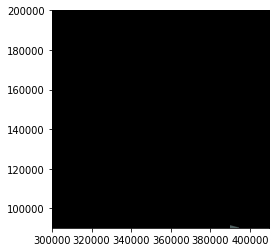

In [81]:
with rio.open('test.jp2') as img:
  print(img.crs)
  rio.plot.show(img)

Downloaded Sentinel-2 imagery manually from Google drive to mark ship locations as points in QGIS 